# Simple Photometric Stereo Example Notebook

## Import Library

In [1]:
from tqdm import tqdm 
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time

## Read image from file

source link : [https://github.com/xiumingzhang/photometric-stereo/tree/master](https://github.com/xiumingzhang/photometric-stereo/tree/master)

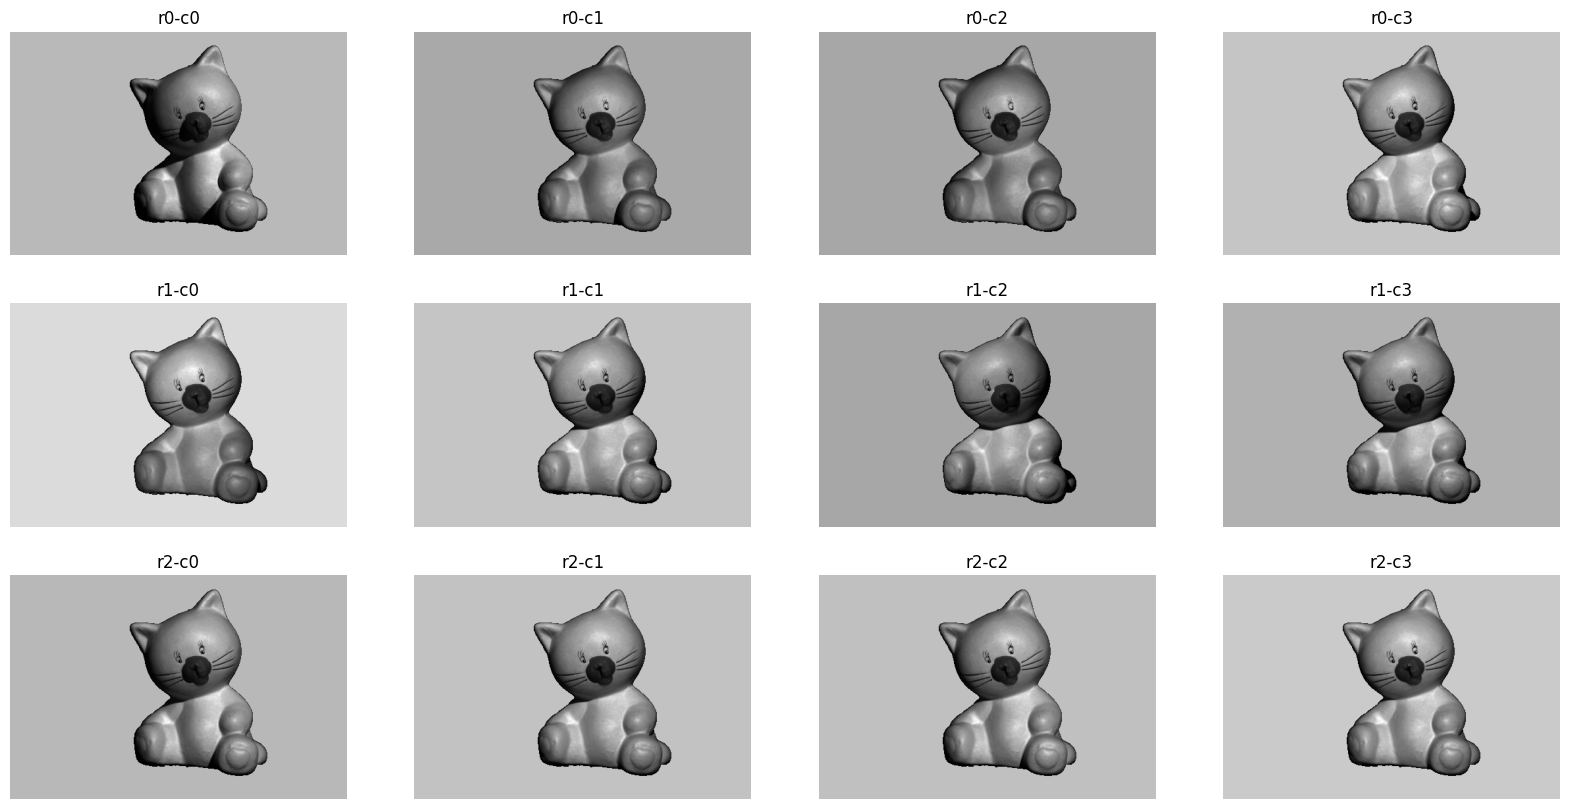

In [2]:
path = './sample'
os.listdir(path)
image_mask = [plt.imread(fname=os.path.join(path, file)) for file in os.listdir(path) if file.endswith('.mask.png')][0]
images_raw = [plt.imread(fname=os.path.join(path, file)) for file in os.listdir(path) if not file.endswith('.mask.png')]
for img in images_raw:
    img[image_mask == 0] = 126/255.
images = [np.average(img, axis=2) for img in images_raw]
sub_plot_rows = int(math.sqrt(len(images)))
sub_plot_cols = math.ceil(len(images)/sub_plot_rows)
fig, axis = plt.subplots(sub_plot_rows, sub_plot_cols)
fig.set_figwidth(20)
fig.set_figheight(10)
for i,image in enumerate(images):
    row, col = int(i/sub_plot_cols) , int(i%sub_plot_cols)
    axis[row, col].set_title(f"r{row}-c{col}")
    axis[row, col].set_axis_off()
    axis[row, col].imshow(image, cmap='gray')
images = np.array(images)

## Create Light Vector

![Right-Handed Cartesian Coordinates System](https://learn.microsoft.com/en-us/previous-versions/windows/desktop/images/bb324490.leftrght(en-us,vs.85).gif)

좌표축은 [Right-Handed Cartesian Coordinates System](https://learn.microsoft.com/en-us/previous-versions/windows/desktop/bb324490%28v=vs.85%29)을 기준으로 합니다.

이미지를 기준으로 오른쪽 방향이 x축, 위 방향이 y축, 이미지에서 카메라 쪽으로 향하는 방향을 z축으로 정의하고 진행합니다.

In [3]:
# light vector의 정보를 가져옵니다.
with open("./lights.txt", 'r') as file:
    text = [line for line in file]

# '\n'을 제거하고 분리한 뒤, deserialize합니다.
raw_light_vectors = [[float(v) if i != 2 else float(v) for i, v in enumerate(t[:-1].split())] for t in text]
print(raw_light_vectors)

[[0.403259, 0.480808, 0.778592], [0.0982272, 0.163712, 0.981606], [-0.0654826, 0.180077, 0.98147], [-0.127999, 0.431998, 0.892745], [-0.328606, 0.485085, 0.810377], [-0.110339, 0.53593, 0.837021], [0.239071, 0.41439, 0.878138], [0.0642302, 0.417497, 0.906406], [0.12931, 0.339438, 0.931698], [0.0323953, 0.340151, 0.939813], [0.0985318, 0.0492659, 0.993914], [-0.16119, 0.354617, 0.92101]]


In [4]:
def convert_vector_to_angle(vector):
    angle_z_axis = math.degrees(math.atan2(vector[2], math.sqrt(math.pow(vector[0], 2) + math.pow(vector[1],2))))
    angle_xy_plane = math.degrees(math.atan2(vector[1], vector[0]))
    return angle_xy_plane, angle_z_axis

# 'raw_light_vectors'는 바로 계산에 사용할 수 있지만, 원래라면 저 vector는 알지 못하고, 각도만 알고있는 상황일 것입니다.
# 이를 재현하기 위해 light vector를 다시 angle로 변환합니다.
light_angles = [convert_vector_to_angle(v) for v in raw_light_vectors]
for i, angle in enumerate(light_angles):
    print(f'Shot {i:2d} : 이미지 기준 {angle[0]:.0f}도 방향으로 {angle[1]:.0f}도의 입사각으로 물체에 조명을 조사')

Shot  0 : 이미지 기준 50도 방향으로 51도의 입사각으로 물체에 조명을 조사
Shot  1 : 이미지 기준 59도 방향으로 79도의 입사각으로 물체에 조명을 조사
Shot  2 : 이미지 기준 110도 방향으로 79도의 입사각으로 물체에 조명을 조사
Shot  3 : 이미지 기준 107도 방향으로 63도의 입사각으로 물체에 조명을 조사
Shot  4 : 이미지 기준 124도 방향으로 54도의 입사각으로 물체에 조명을 조사
Shot  5 : 이미지 기준 102도 방향으로 57도의 입사각으로 물체에 조명을 조사
Shot  6 : 이미지 기준 60도 방향으로 61도의 입사각으로 물체에 조명을 조사
Shot  7 : 이미지 기준 81도 방향으로 65도의 입사각으로 물체에 조명을 조사
Shot  8 : 이미지 기준 69도 방향으로 69도의 입사각으로 물체에 조명을 조사
Shot  9 : 이미지 기준 85도 방향으로 70도의 입사각으로 물체에 조명을 조사
Shot 10 : 이미지 기준 27도 방향으로 84도의 입사각으로 물체에 조명을 조사
Shot 11 : 이미지 기준 114도 방향으로 67도의 입사각으로 물체에 조명을 조사


In [5]:
def get_light_normal_vector(angle_for_xy_plane, angle_for_z_axis):
    rad_xy, rad_z = math.radians(angle_for_xy_plane), math.radians(angle_for_z_axis)
    return [math.cos(rad_xy)*math.cos(rad_z), math.sin(rad_xy)*math.cos(rad_z), math.sin(rad_z)]

# light의 angle로부터 light vector를 계산합니다.
light_vector = np.array([get_light_normal_vector(a[0], a[1]) for a in light_angles])
inv_light_vector = np.linalg.pinv(light_vector)

print(f"Error : {np.sum(np.abs(np.array(raw_light_vectors) - light_vector)):0.0f}")
print(f"light_vector : \n{light_vector}")
print(f" - shape : {light_vector.shape} | Light vector는 n x 3 형태가 됩니다.\n")
print(f"inv_light_vector : \n{inv_light_vector}")
print(f" - shape : {inv_light_vector.shape} | Light vector는 3 x n 형태가 됩니다.\n")
print(f"light_vector x inv_light_vector : \n{light_vector @ inv_light_vector}")

Error : 0
light_vector : 
[[ 0.40325907  0.48080808  0.77859213]
 [ 0.09822717  0.16371196  0.98160573]
 [-0.06548263  0.18007708  0.98147046]
 [-0.12799902  0.43199808  0.89274516]
 [-0.32860596  0.48508494  0.8103769 ]
 [-0.11033901  0.53593005  0.83702108]
 [ 0.23907096  0.41438992  0.87813784]
 [ 0.06423016  0.41749677  0.9064055 ]
 [ 0.12930997  0.33943793  0.93169782]
 [ 0.03239529  0.34015089  0.9398127 ]
 [ 0.09853177  0.04926588  0.99391366]
 [-0.16119041  0.35461791  0.92101237]]
 - shape : (12, 3) | Light vector는 n x 3 형태가 됩니다.

inv_light_vector : 
[[ 9.73092455e-01  1.20741203e-01 -2.66762408e-01 -3.31598743e-01
  -7.83783945e-01 -2.51155053e-01  5.45030359e-01  1.22523864e-01
   2.52449557e-01  1.92045204e-02  8.74747918e-02 -4.37337389e-01]
 [ 7.00763261e-01 -6.17280586e-01 -6.11608330e-01  2.64754334e-01
   4.72130566e-01  6.60996601e-01  3.29410553e-01  2.56941752e-01
   7.65945263e-04 -3.36568487e-02 -9.90239518e-01 -2.02692540e-02]
 [-2.07201031e-01  3.27541499e-01  3

## Calc surface normal vectors

Current Images's shape : (12, 340, 512)
Reshaped Images's shape : (340, 512, 12)


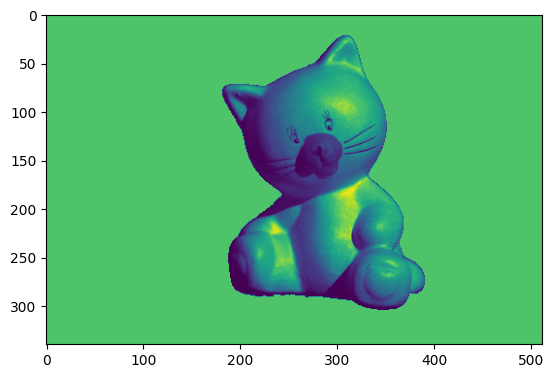

In [6]:
# numpy를 활용하여 계산하기 위해, axis를 변경합니다.
rs_images = np.transpose(images, (1,2,0))
plt.imshow(rs_images[:,:,0])
print(f"Current Images's shape : {images.shape}")
print(f"Reshaped Images's shape : {rs_images.shape}")

In [7]:
# 처리에 사용한 데이터의 크기를 기록합니다.
number_of_pixel_per_image = rs_images.shape[0] * rs_images.shape[1]
number_of_images = rs_images.shape[2]

# 시작 시간 기록합니다.
start = time.time()  

# 결과 이미지를 생성합니다.
surface_normal = rs_images @ inv_light_vector.T
surface_normal_norm = np.repeat(np.linalg.norm(surface_normal, axis=2), repeats=3).reshape(surface_normal.shape)
surface_normal = surface_normal / surface_normal_norm
albedo = surface_normal_norm
surface_normal_x = surface_normal[:,:,0]
surface_normal_y = surface_normal[:,:,1]
surface_normal_z = surface_normal[:,:,2]

# 생성에 소요된 시간을 측정합니다.
processing_time = (time.time() - start) * 1000

# 소요 시간, 처리한 데이터양을 표시합니다.
print(f"Processing time : {processing_time:0.00f}[ms] | Image Resolution : {rs_images.shape[1]} x {rs_images.shape[0]} | Number of pixel per image : {number_of_pixel_per_image} | Number of used image : {number_of_images}")  # 현재시각 - 시작시간 = 실행 시간

Processing time : 24[ms] | Image Resolution : 512 x 340 | Number of pixel per image : 174080 | Number of used image : 12


/tmp/ipykernel_20464/735739081.py:11: RuntimeWarning: invalid value encountered in divide
  surface_normal = surface_normal / surface_normal_norm


## Show Result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/root/.local/share/virtualenvs/Study.PhotometricStereo-qUyzx-uC/lib/python3.9/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


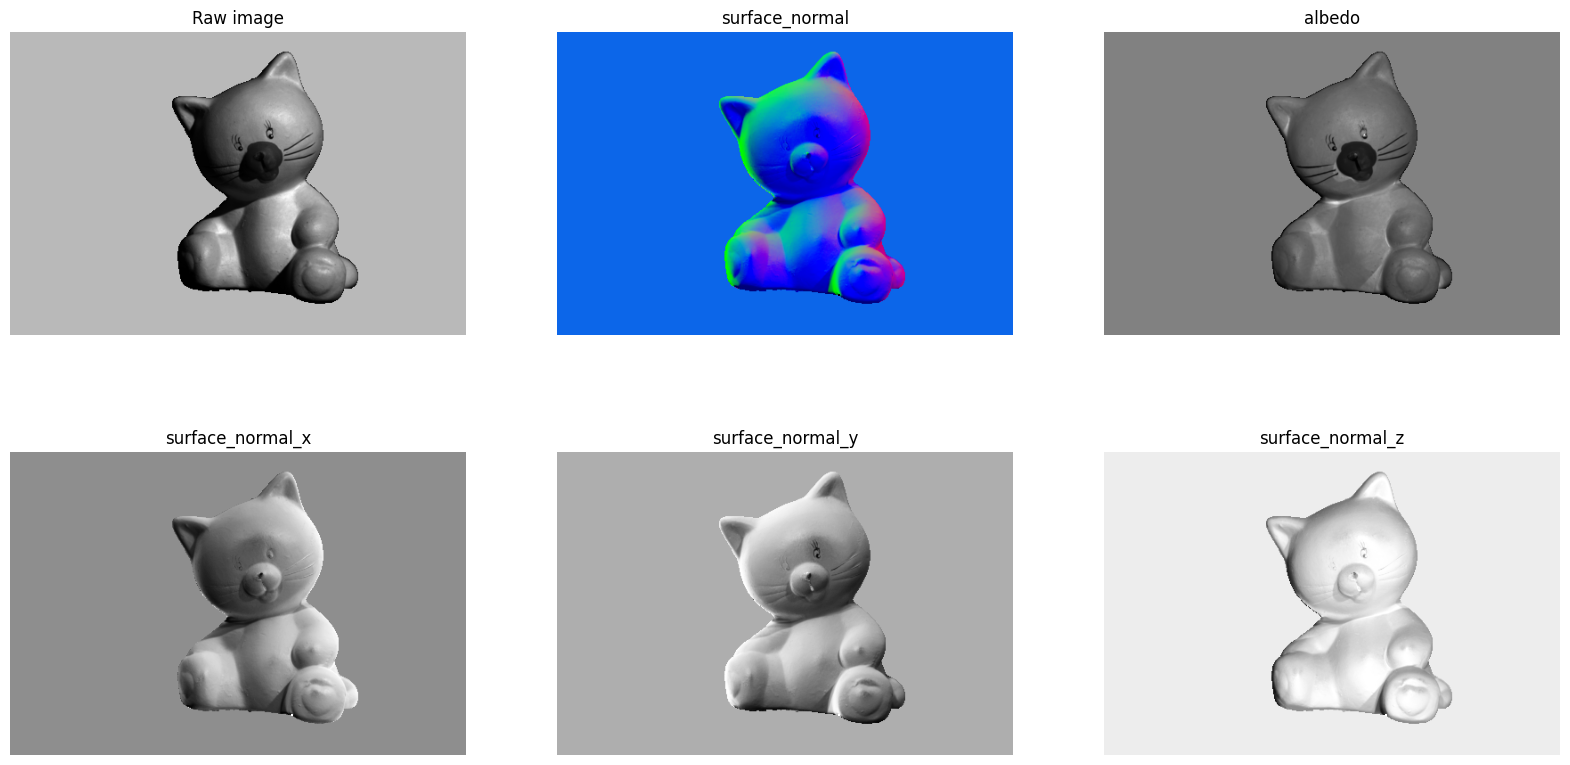

In [8]:
fig, axises = plt.subplots(2,3)
fig.set_size_inches(20,10)
for a in axises : 
    for _a in a:
        _a.set_axis_off() 
axises[0][0].set_title('Raw image')
axises[0][0].imshow(images[0], cmap='gray')
axises[0][1].set_title('surface_normal')
axises[0][1].imshow(surface_normal, cmap='gray')
axises[0][2].set_title('albedo')
axises[0][2].imshow(surface_normal_norm, cmap='gray')
axises[1][0].set_title('surface_normal_x')
axises[1][0].imshow(surface_normal_x, cmap='gray')
axises[1][1].set_title('surface_normal_y')
axises[1][1].imshow(surface_normal_y, cmap='gray')
axises[1][2].set_title('surface_normal_z')
axises[1][2].imshow(surface_normal_z, cmap='gray')